In [98]:
import numpy as np
import tensorflow as tf
import os

In [2]:
a = {
        'conv1d_1': {'name': 'conv1d_1', 'weight_shape': [3, 1, 64], 'stride': 1, 'padding': 'SAME'},
        'conv1d_2': {'name': 'conv1d_2', 'weight_shape': [3, 64, 64], 'stride': 1, 'padding': 'SAME'},
        'pool_1': {'name': 'pool_1', 'kernel': [1, 2, 1], 'stride': 1, 'is_max_pool': True, 'padding': 'SAME'},
        'dropout_1': {'name': 'dropout_1', 'rate': 0.2},

        'conv1d_3': {'name': 'conv1d_3', 'weight_shape': [3, 64, 128], 'stride': 1, 'padding': 'SAME'},
        'conv1d_4': {'name': 'conv1d_4', 'weight_shape': [3, 128, 128], 'stride': 1, 'padding': 'SAME'},
        'pool_2': {'name': 'pool_2', 'kernel': [1, 2, 1], 'stride': 1, 'is_max_pool': True, 'padding': 'SAME'},
        'dropout_2': {'name': 'dropout_1', 'rate': 0.2},

        'conv1d_5': {'name': 'conv1d_5', 'weight_shape': [3, 128, 256], 'stride': 1, 'padding': 'SAME'},
        'conv1d_6': {'name': 'conv1d_6', 'weight_shape': [3, 256, 256], 'stride': 1, 'padding': 'SAME'},
        'pool_3': {'name': 'pool_3', 'kernel': [1, 2, 1], 'stride': 1, 'is_max_pool': True, 'padding': 'SAME'},
        'dropout_3': {'name': 'dropout_1', 'rate': 0.2},

        'conv1d_7': {'name': 'conv1d_7', 'weight_shape': [3, 256, 512], 'stride': 1, 'padding': 'SAME'},
        'conv1d_8': {'name': 'conv1d_8', 'weight_shape': [3, 512, 512], 'stride': 1, 'padding': 'SAME'},
        'pool_4': {'name': 'pool_3', 'kernel': [1, 2, 1], 'stride': 1, 'is_max_pool': True, 'padding': 'SAME'},
        'dropout_4': {'name': 'dropout_1', 'rate': 0.2},

        'conv1d_9': {'name': 'conv1d_9', 'weight_shape': [3, 512, 512], 'stride': 1, 'padding': 'SAME'},
        'conv1d_10': {'name': 'conv1d_10', 'weight_shape': [3, 512, 512], 'stride': 1, 'padding': 'SAME'},
        'pool_5': {'name': 'pool_3', 'kernel': [1, 2, 1], 'stride': 1, 'is_max_pool': True, 'padding': 'SAME'},

        'fulcon1': {'name': 'fulcon1', 'weight_shape': [65536, 4096]},
        'softmax': {'name': 'softmax', 'weight_shape': [4096, 6]},
    }


In [3]:
    for layer_id in a.items():
        if not ('pool' in layer_id[0] or 'dropout' in layer_id[0]):
            with tf.compat.v1.variable_scope(layer_id[1]['name']):
                tf.compat.v1.get_variable(name='weights',
                                          shape=layer_id[1]['weight_shape'],
                                          initializer=tf.contrib.layers.xavier_initializer())
                tf.compat.v1.get_variable(name='biases',
                                          shape=layer_id[1]['weight_shape'][-1],
                                          initializer=tf.constant_initializer(0.0))


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
def logits(tf_input, layers, batch_size):
    h = tf_input
    for layer_id in layers.items():
        if 'conv1d' in layer_id[0]:
            with tf.compat.v1.variable_scope(layer_id[1]['name'], reuse=True):
                w, b = tf.compat.v1.get_variable('weights'), tf.compat.v1.get_variable('biases')
                h = tf.nn.conv1d(h, w, layer_id[1]['stride'], padding=layer_id[1]['padding'], name='conv')
                h = tf.nn.bias_add(h, b, name='bias_add')
                h = tf.nn.relu(h, name='relu')
        if 'pool' in layer_id[0]:
            with tf.compat.v1.variable_scope(layer_id[1]['name']):
                if layer_id[1]['is_max_pool']:
                    h = tf.nn.max_pool1d(h, layer_id[1]['kernel'], layer_id[1]['stride'],
                                         padding=layer_id[1]['padding'], name='pool')
                else:
                    h = tf.nn.avg_pool1d(h, layer_id[1]['kernel'], layer_id[1]['stride'],
                                         padding=layer_id[1]['padding'], name='pool')
        if 'fulcon' in layer_id[0]:
            with tf.compat.v1.variable_scope(layer_id[1]['name'], reuse=True):
                w, b = tf.compat.v1.get_variable('weights'), tf.compat.v1.get_variable('biases')
                flat_x = tf.reshape(h, [batch_size, -1])
                h = tf.nn.bias_add(tf.matmul(flat_x, w), b)
                h = tf.nn.relu(h)
        if 'softmax' in layer_id[0]:
            with tf.compat.v1.variable_scope(layer_id[1]['name'], reuse=True):
                w, b = tf.compat.v1.get_variable('weights'), tf.compat.v1.get_variable('biases')
                h = tf.nn.bias_add(tf.matmul(flat_x, w), b)
        if 'norm' in layer_id[0]:
            epsilon = 1e-3
            h = tf.layers.batch_normalization(h, epsilon=epsilon, training=layer_id[1]['training'])
    return h


In [ ]:
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits(tf_inputs, a), labels=tf_labels))
tf_loss_minimize = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(tf_loss)

In [49]:
b = np.ones((32, 6))
TRAIN_LENGTH = 0.2
LENGTH = 5229

In [18]:
test_labels = b[int(TRAIN_LENGTH * LENGTH):, ]

In [50]:
np.argmax(b, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [47]:
a.append(2)

In [48]:
listdir = os.listdir('D:\\data\\esr2019_hcmus\\Train')

In [52]:
listdir = ['D:\\data\\esr2019_hcmus\\Train' + f for f in listdir]

In [56]:
listdir.flatten()

AttributeError: 'list' object has no attribute 'flatten'

In [71]:
 mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, (32, 6))

In [74]:
np.argmax(s, axis=1).flatten() 

array([2, 4, 5, 5, 1, 3, 2, 2, 2, 3, 1, 5, 5, 0, 0, 3, 4, 4, 4, 3, 1, 4,
       4, 1, 2, 2, 3, 0, 2, 5, 4, 5], dtype=int64)

In [75]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


Using TensorFlow backend.


In [91]:
y = [0, 1, 3, 5, 1, 3, 4, 2, 2, 5, 6]
x = [4, 9, 6, 8, 1, 2, 3, 5, 1, 4, 9]

In [83]:
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [89]:
yy[0 * 2: (0 + 1) * 2,:].shape

(2, 7)

In [90]:
import matplotlib.pyplot as plt

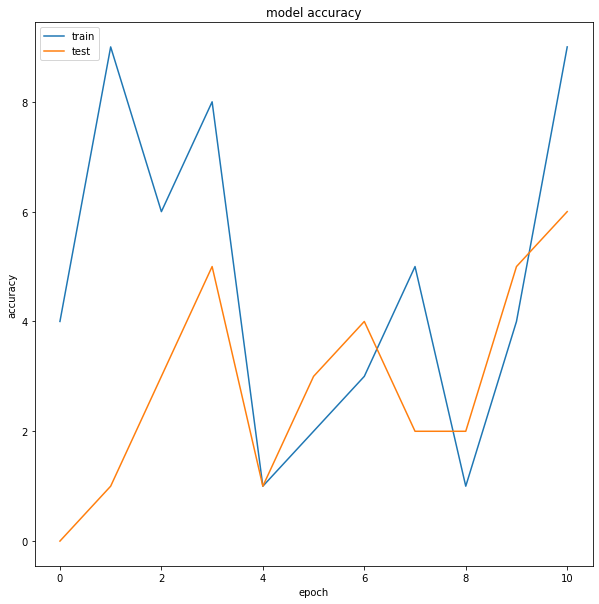

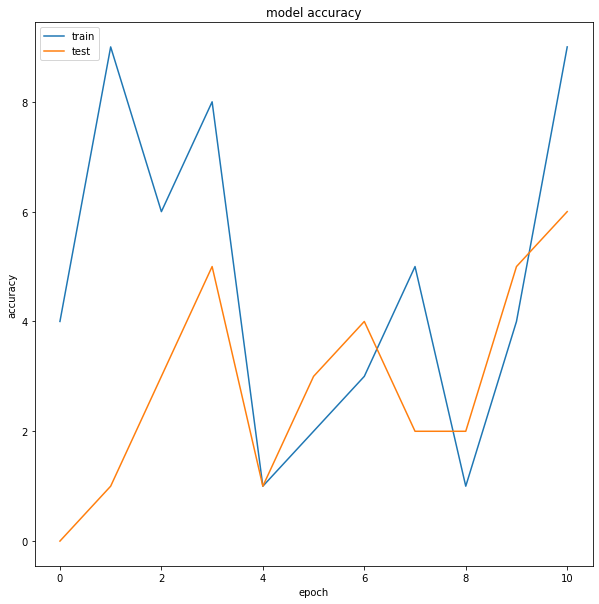

In [97]:
fig = plt.figure(figsize=(10, 10))
plt.plot(x)
plt.plot(y)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('temp.png', dpi=fig.dpi)


fig = plt.figure(figsize=(10, 10))
plt.plot(x)
plt.plot(y)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('temp1.png', dpi=fig.dpi)

In [102]:
with tf.name_scope('some_scope1'):
    a = tf.Variable(1, name='a')
    b = tf.Variable(2, name='b')
    c = tf.Variable(3, name='c')

with tf.name_scope('some_scope2'):
    d = tf.Variable(4, name='d')
    e = tf.Variable(5, name='e')
    f = tf.Variable(6, name='f')

h = tf.Variable(8, 'h')



some_scope1/Variable:0
some_scope1/Variable_1:0
some_scope1/Variable_2:0
some_scope2/Variable:0
some_scope2/Variable_1:0
some_scope2/Variable_2:0
some_scope1_1/a:0
some_scope1_1/b:0
some_scope1_1/c:0
some_scope2_1/d:0
some_scope2_1/e:0
some_scope2_1/f:0
some_scope1_2/a:0
some_scope1_2/b:0
some_scope1_2/c:0
some_scope2_2/d:0
some_scope2_2/e:0
some_scope2_2/f:0


In [109]:
for i in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='some_scope'):
    if 'some_scope1' in i.name:
        print(i.name)

some_scope1/Variable:0
some_scope1/Variable_1:0
some_scope1/Variable_2:0
some_scope1_1/a:0
some_scope1_1/b:0
some_scope1_1/c:0
some_scope1_2/a:0
some_scope1_2/b:0
some_scope1_2/c:0
